In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Mis modulos
from src.graficar import graficar_serie

# Pythorch
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.optim as optim

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, r2_score

In [182]:
ruta = 'data/clean_data/nasdaq.csv'
serie = pd.read_csv(ruta, names = ['Valores'])
serie.head()

,Valores
0,459.33
1,460.90
2,459.39
3,458.22
4,458.71


### Preprocesamiento de la serie de tiempo

------------ Transformación ----------
 - Logaritmo
 - Diferenciación
 - Normalización

---------- Reconstrucción ----------
 - Media y std
- Primer valor
 - Exponencial

In [183]:
# Transformación

# Logaritmo
s_log = np.log(serie['Valores'].values)
# Difereniación simple
s_diff = np.diff(s_log, n=1) # Falta definirle el s_prev depsues el split
# Normalización
scaler = StandardScaler()
s_norm = scaler.fit_transform(s_diff.reshape(-1,1)).flatten()
mu = scaler.mean_[0]
sigma = scaler.scale_[0]

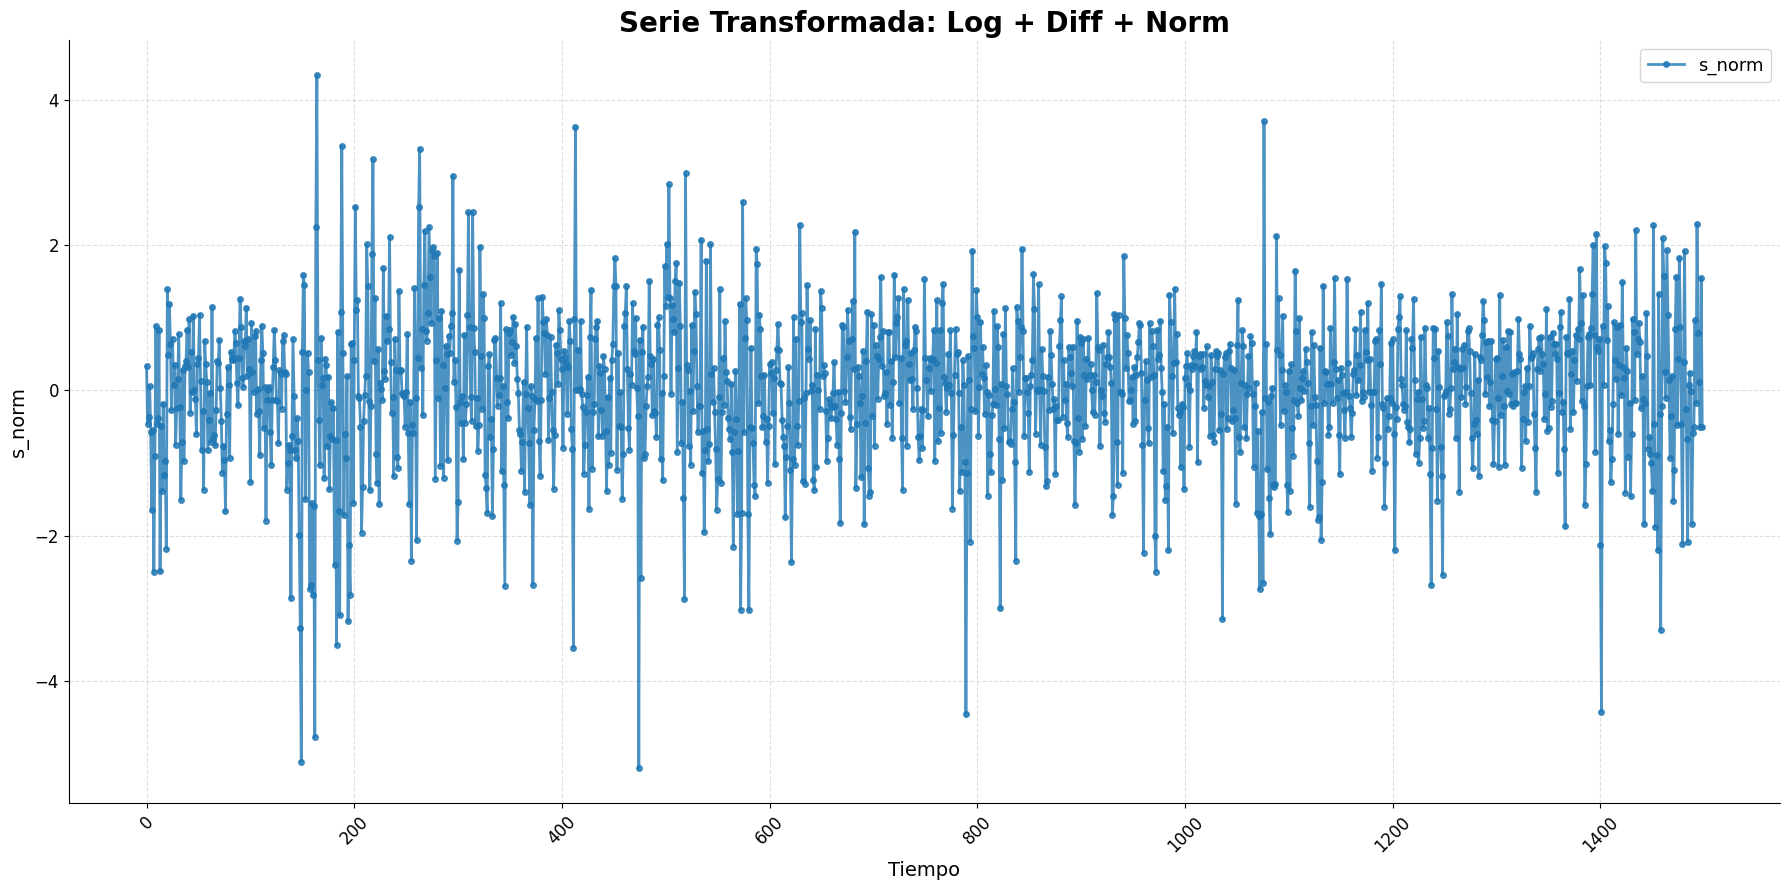

In [184]:
df_s_norm = pd.DataFrame({'s_norm': s_norm})
graficar_serie(df_s_norm, 's_norm', titulo='Serie Transformada: Log + Diff + Norm')

### Validación de la serie usando Data Loader

In [185]:
def crear_ventanas(serie, ventana):
    X, y = [], []
    for i in range(len(serie) - ventana):
        X.append(serie[i : i + ventana])
        y.append(serie[i + ventana])
    return np.array(X), np.array(y)

In [186]:
ventana = 100
X, y = crear_ventanas(df_s_norm.values.flatten(), ventana)

# Proporciones para conjuntos
n = len(X)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Respetar la dependencia temporal
X_train = X[:train_end]
y_train = y[:train_end]

X_val = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test = X[val_end:]
y_test = y[val_end:]

# Trabajar con tensores
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val   = torch.tensor(X_val,   dtype=torch.float32).unsqueeze(1)
X_test  = torch.tensor(X_test,  dtype=torch.float32).unsqueeze(1)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val   = torch.tensor(y_val,   dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32)

# Crear los Datasets con shuffle = False
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)
test_dataset  = TensorDataset(X_test,  y_test)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


In [187]:
for xb, yb in train_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([32, 1, 100]) torch.Size([32])


### Estructura de la Red Convolucional para Conv1

In [188]:
class Conv1DRegressor(nn.Module):
    def __init__(self, window_size):
        super().__init__()
        self.conv_layers = nn.Sequential(

            # ----- Bloque 1 -----
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),     # 100 → 50

            # ----- Bloque 2 -----
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),     # 50 → 25

            # ----- Bloque 3 -----
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(5),     # 25 → 5

            # ----- Bloque 4 extra (nuevo) -----
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.AdaptiveAvgPool1d(1)   # 5 → 1
        )

        # ----- MLP final -----
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)     # (batch, 256, 1)
        x = x.squeeze(-1)           # (batch, 256)
        return self.fc(x)

In [189]:
model = Conv1DRegressor(window_size=ventana)
print(f'Parámetros totales: {sum(p.numel() for p in model.parameters())}')
# 257505

Parámetros totales: 257505


### Instanciar la Red, Pérdida y Optimizador

In [190]:
# MSE y optimizador
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(),
                       lr=1e-4,
                       weight_decay=1e-4) 

# Ajustar el lr
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5
)

### Función de entrenamiento 

In [191]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Entrena una época completa en CPU"""
    model.train()
    train_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % 50 == 0:
            print(f'  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')
    
    return train_loss / len(train_loader)


def validate_epoch(model, val_loader, criterion):
    """Evalúa el modelo en el conjunto de validación en CPU"""
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))
            val_loss += loss.item()
    
    return val_loss / len(val_loader)

In [192]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler, epochs=100, patience=15):
    """
    Entrena el modelo con early stopping (CPU)
    """
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        print(f'\nÉpoca {epoch+1}/{epochs}')
        print('-' * 40)
        
        # Entrenar
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        
        # Validar
        val_loss = validate_epoch(model, val_loader, criterion)
        val_losses.append(val_loss)
        
        print(f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # Ajustar learning rate
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f'Mejor modelo guardado (Val Loss: {val_loss:.6f})')
        else:
            patience_counter += 1
            print(f'Sin mejora ({patience_counter}/{patience})')
            
        if patience_counter >= patience:
            print(f'\nEarly stopping en época {epoch+1}')
            break
    
    # Cargar el mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

### Entrenamiento

In [193]:
epochs = 100
patience = 20

model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=epochs,
    patience=patience
)


Época 1/100
----------------------------------------
  Batch 0/35, Loss: 0.419607
Train Loss: 1.059731, Val Loss: 0.495697
Mejor modelo guardado (Val Loss: 0.495697)

Época 2/100
----------------------------------------
  Batch 0/35, Loss: 0.392217
Train Loss: 1.054804, Val Loss: 0.499315
Sin mejora (1/20)

Época 3/100
----------------------------------------
  Batch 0/35, Loss: 0.415843
Train Loss: 1.047632, Val Loss: 0.504977
Sin mejora (2/20)

Época 4/100
----------------------------------------
  Batch 0/35, Loss: 0.393372
Train Loss: 1.046585, Val Loss: 0.516093
Sin mejora (3/20)

Época 5/100
----------------------------------------
  Batch 0/35, Loss: 0.400460
Train Loss: 1.042159, Val Loss: 0.523812
Sin mejora (4/20)

Época 6/100
----------------------------------------
  Batch 0/35, Loss: 0.399000
Train Loss: 1.033330, Val Loss: 0.548696
Sin mejora (5/20)

Época 7/100
----------------------------------------
  Batch 0/35, Loss: 0.415721
Train Loss: 1.040011, Val Loss: 0.562512

### Visualizar resultados entrenamiento

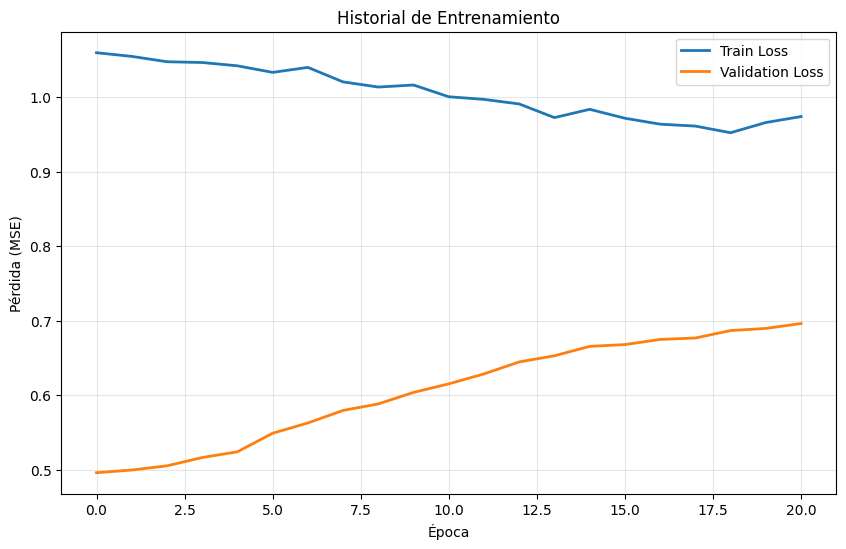

In [194]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.xlabel('Época')
    plt.ylabel('Pérdida (MSE)')
    plt.title('Historial de Entrenamiento')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_training_history(train_losses, val_losses)

### Evaluar en Test

In [197]:
train_size = int(len(s_diff) * 0.8)
x_prev = s_log[train_size]  

In [198]:
def reconstruir_secuencia(diff_seq, x_prev):
    pred_log = np.zeros(len(diff_seq) + 1)
    pred_log[0] = x_prev
    pred_log[1:] = x_prev + np.cumsum(diff_seq)
    return np.exp(pred_log)

def evaluate_model(model, test_loader, criterion, mu, sigma, x_prev):
    model.eval()
    test_loss = 0.0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            loss = criterion(pred, y.unsqueeze(1))
            test_loss += loss.item()

            predictions.extend(pred.numpy().flatten())
            targets.extend(y.numpy())

    test_loss /= len(test_loader)
    predictions = np.array(predictions)
    targets     = np.array(targets)
    
    # ---------------------- Métricas en diferencias ----------------------
    predictions_denorm = predictions * sigma + mu
    targets_denorm     = targets * sigma + mu
    
    mae_diff  = mean_absolute_error(targets_denorm, predictions_denorm)
    r2_diff   = r2_score(targets_denorm, predictions_denorm)
    rmse_diff = np.sqrt(test_loss)

    print("\n===== EVALUACIÓN (ESCALA DIFERENCIADA) =====")
    print(f"  RMSE: {rmse_diff:.4f}")
    print(f"  MAE : {mae_diff:.4f}")
    print(f"  R²  : {r2_diff:.4f}")

    # ---------------------- Reconstrucción continua ----------------------
    pred_recon  = reconstruir_secuencia(predictions_denorm, x_prev)
    true_recon  = reconstruir_secuencia(targets_denorm, x_prev)

    mse_real  = mean_squared_error(true_recon, pred_recon)
    mae_real  = mean_absolute_error(true_recon, pred_recon)
    r2_real   = r2_score(true_recon, pred_recon)
    rmse_real = np.sqrt(mse_real)

    print("\n===== EVALUACIÓN (ESCALA ORIGINAL) =====")
    print(f"  MSE : {mse_real:.4f}")
    print(f"  RMSE: {rmse_real:.4f}")
    print(f"  MAE : {mae_real:.4f}")
    print(f"  R²  : {r2_real:.4f}")
    
    return predictions_denorm, targets_denorm, pred_recon, true_recon


In [199]:
predictions, targets, pred_recon, target_recon = evaluate_model(model,
                                                                test_loader,
                                                                criterion,
                                                                mu,
                                                                sigma,
                                                                x_prev)


===== EVALUACIÓN (ESCALA DIFERENCIADA) =====
  RMSE: 1.2714
  MAE : 0.0088
  R²  : -0.2871

===== EVALUACIÓN (ESCALA ORIGINAL) =====
  MSE : 97235.7384
  RMSE: 311.8265
  MAE : 279.2555
  R²  : -33.0965


### Visualizar predicción vs real

In [200]:
df_real = pd.DataFrame({"Valores": target_recon})
df_pred = pd.DataFrame({"Reconstruida": pred_recon})

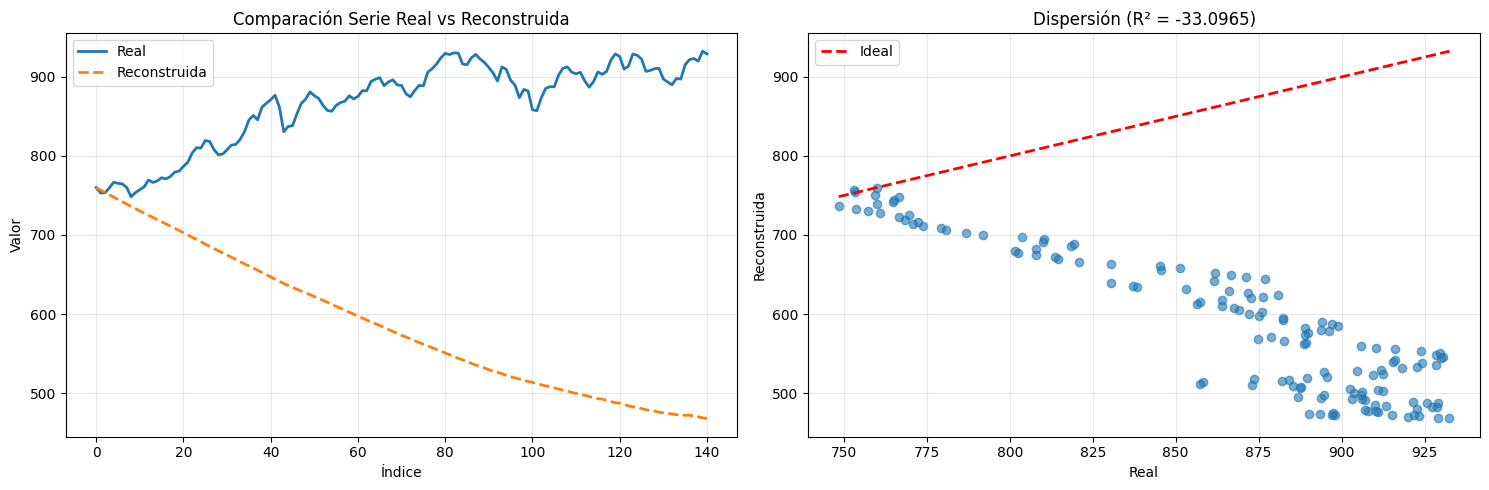

In [201]:
def comparar_series(df_real, df_pred, col_real="Valores", col_pred="Reconstruida",
                    titulo="Comparación Serie Real vs Reconstruida"):
    # --- Convertir a arrays ---
    real = df_real[col_real].values
    pred = df_pred[col_pred].values

    # --- Alinear longitudes ---
    L = min(len(real), len(pred))
    real = real[-L:]
    pred = pred[-L:]

    # --- Calcular R² ---
    r2 = r2_score(real, pred)

    # --- Gráfica de líneas ---
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(real, label="Real", linewidth=2)
    plt.plot(pred, label="Reconstruida", linestyle="--", linewidth=2)
    plt.title(titulo)
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # --- Gráfica de dispersión ---
    plt.subplot(1, 2, 2)
    plt.scatter(real, pred, alpha=0.6)
    plt.plot([real.min(), real.max()], [real.min(), real.max()], "r--",
             label="Ideal", linewidth=2)
    plt.title(f"Dispersión (R² = {r2:.4f})")
    plt.xlabel("Real")
    plt.ylabel("Reconstruida")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()
comparar_series(df_real, df_pred)

### Guardar modelo entrenado

In [110]:
def save_model(model, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'window_size': ventana,
        'input_shape': (1, ventana)
    }, path)
    print(f'Modelo guardado en {path}')

save_model(model, 'time_series_cnn_model.pth')

Modelo guardado en time_series_cnn_model.pth


### Predicciónes futuras

In [143]:
def predecir_futuro(model, serie, ventana, n_pasos=10):
    model.eval()
    predicciones = []
    
    ultima_ventana = serie[-ventana:].copy()
    
    with torch.no_grad():
        for _ in range(n_pasos):
            x = torch.tensor(ultima_ventana, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            pred = model(x).numpy()[0, 0]
            predicciones.append(pred)
            
            ultima_ventana = np.roll(ultima_ventana, -1)
            ultima_ventana[-1] = pred
    
    return np.array(predicciones)

# Ejemplo:
# predicciones_futuras = predecir_futuro(model, serie.values, ventana, n_pasos=20)

In [ ]:
def reconstruir(pred_norm, mu, sigma, x_prev):
    # 1) Desnormalizar
    pred_diff = pred_norm * sigma + mu    

    # 2) Invertir la diferencia
    pred_log = np.zeros(len(pred_diff) + 1)
    pred_log[0] = x_prev
    pred_log[1:] = x_prev + np.cumsum(pred_diff)
    
    # 3) Invertir logaritmo
    pred = np.exp(pred_log)
    return pred
